In [89]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# Chnage scientific figures to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
sns.set(rc={'figure.figsize':(8,6)})

from pandas import to_datetime
import itertools
import warnings
import datetime
warnings.filterwarnings('ignore')

from math import sqrt
import warnings
import seaborn as sns
from itertools import product

from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn .dummy import DummyClassifier 


In [30]:
# %pip install xgboost==1.5.0

In [31]:
# import graphviz

In [90]:
#Load Data

def data_ingestion():
    Features=pd.read_csv("Selected_Feats.csv")["Selected_Features"].tolist()
    Features.append("Dpd")
    data=pd.read_csv("ISW_data_for_Feature_analysis.csv")
    data=data.loc[:,Features]
    print(f'data info \n\n {data.info()}')
    return data






### Problem Formulation

This model is meant to clasiffy loan applicants into bad or good

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2420 entries, 0 to 2419
Data columns (total 11 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   min_credit_amt_last_3_months                        2420 non-null   float64
 1   debits_lowest_negative_balance_last_9_months        2420 non-null   float64
 2   debits_min_debit_amt_last_3_months                  2420 non-null   float64
 3   credits_average_transaction_size_last_3_months      2420 non-null   float64
 4   debits_highest_negative_balance_last_6_months       2420 non-null   float64
 5   debits_average_transaction_size_last_12_months      2420 non-null   float64
 6   debits_highest_negative_balance_last_9_months       2420 non-null   float64
 7   debits_lowest_negative_balance_last_6_months        2420 non-null   float64
 8   credits_average_daily_transactions_last_3_months    2420 non-null   float64
 9

#### Data Pre_processing

In [93]:
def data_pre_processing(data):
    print(f'Null Values \n\n{data.isnull().sum()}')
    print('\n\n Value Counts \n')
    for col in data.columns:
       y=data[col].nunique()
       print (f'{col}: {y}')
rr=data_pre_processing(data)
     
  


Null Values 

min_credit_amt_last_3_months                          0
debits_lowest_negative_balance_last_9_months          0
debits_min_debit_amt_last_3_months                    0
credits_average_transaction_size_last_3_months        0
debits_highest_negative_balance_last_6_months         0
debits_average_transaction_size_last_12_months        0
debits_highest_negative_balance_last_9_months         0
debits_lowest_negative_balance_last_6_months          0
credits_average_daily_transactions_last_3_months      0
debits_unique_negative_balance_dates_last_9_months    0
Dpd                                                   0
dtype: int64


 Value Counts 

min_credit_amt_last_3_months: 5
debits_lowest_negative_balance_last_9_months: 2
debits_min_debit_amt_last_3_months: 14
credits_average_transaction_size_last_3_months: 5
debits_highest_negative_balance_last_6_months: 2
debits_average_transaction_size_last_12_months: 25
debits_highest_negative_balance_last_9_months: 2
debits_lowest_negativ

In [35]:
data.isnull().sum()

min_credit_amt_last_3_months                          0
debits_lowest_negative_balance_last_9_months          0
debits_min_debit_amt_last_3_months                    0
credits_average_transaction_size_last_3_months        0
debits_highest_negative_balance_last_6_months         0
debits_average_transaction_size_last_12_months        0
debits_highest_negative_balance_last_9_months         0
debits_lowest_negative_balance_last_6_months          0
credits_average_daily_transactions_last_3_months      0
debits_unique_negative_balance_dates_last_9_months    0
Dpd                                                   0
dtype: int64

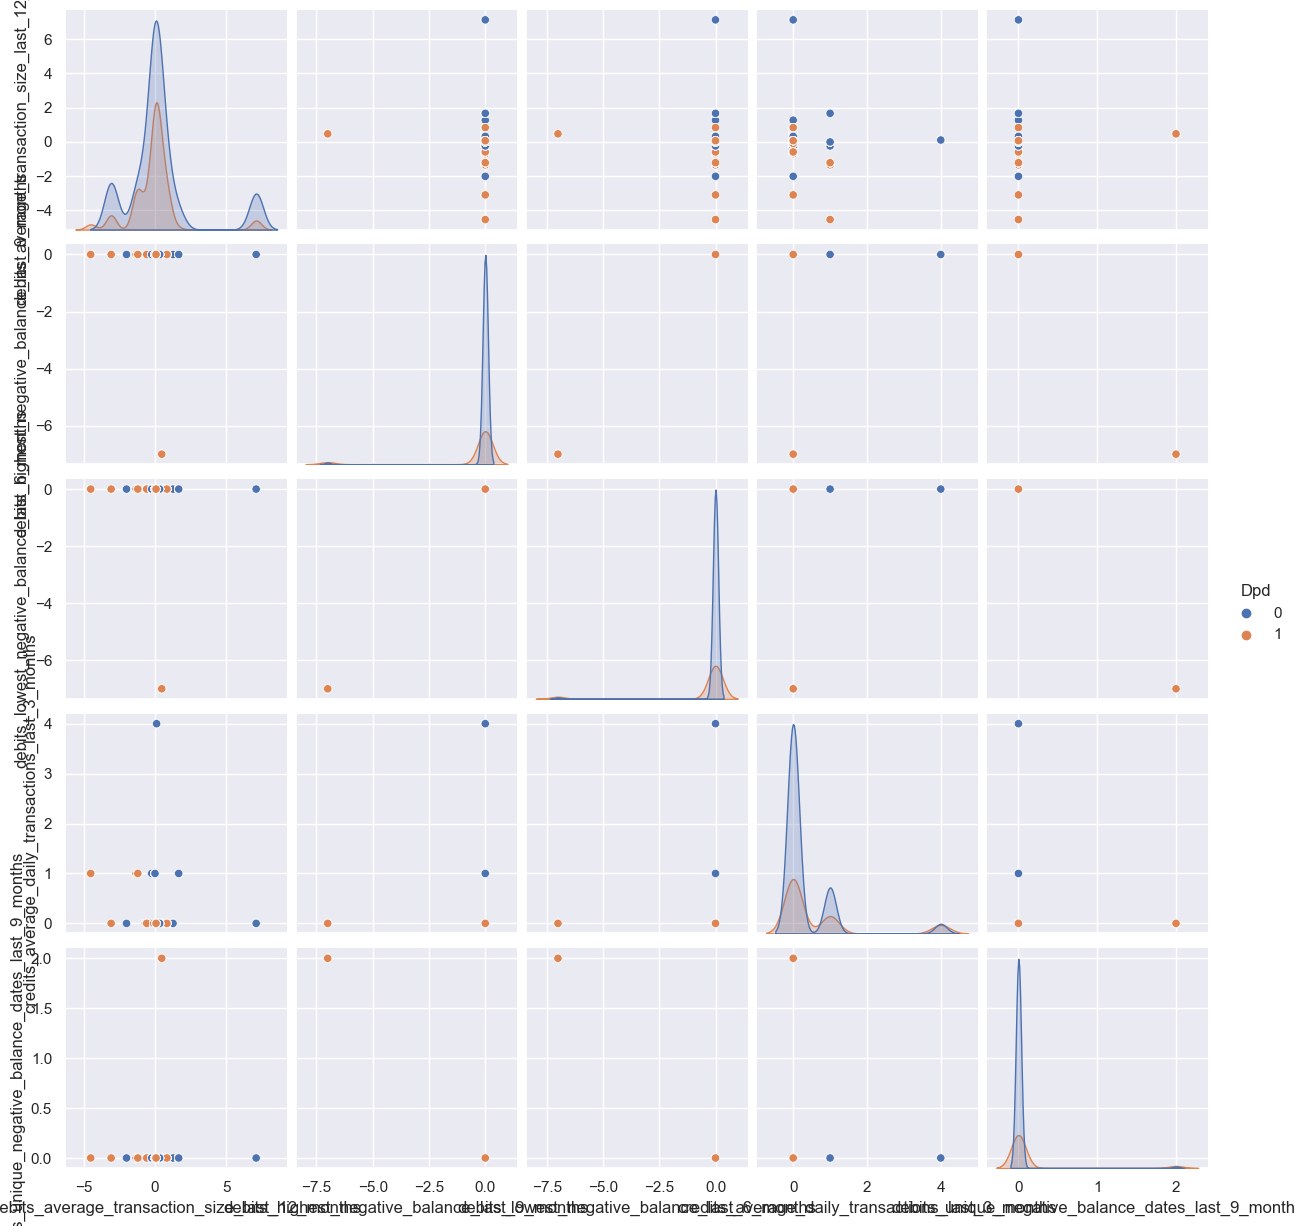

In [94]:
#Feature Relationships
def Feature_Relationships(data):
    pairplot=sns.pairplot(data.iloc[:,5:],hue="Dpd",diag_kws={'bw':0.2})
   
    return pairplot

Rel=Feature_Relationships(data)
Rel
    

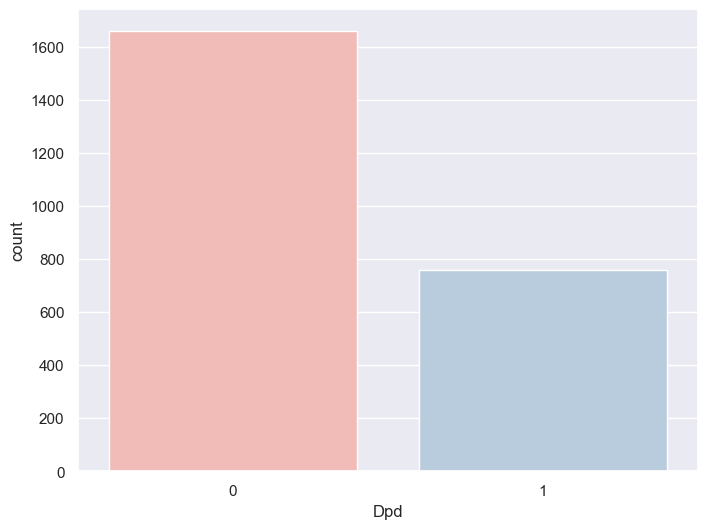

In [95]:
# Investiate distribution of y
def check_data_balance(data):
    plot = sns.set_theme(style="darkgrid", palette="Pastel1"); sns.countplot(x="Dpd", data=data)
    return plot

balance_plot=check_data_balance(data)


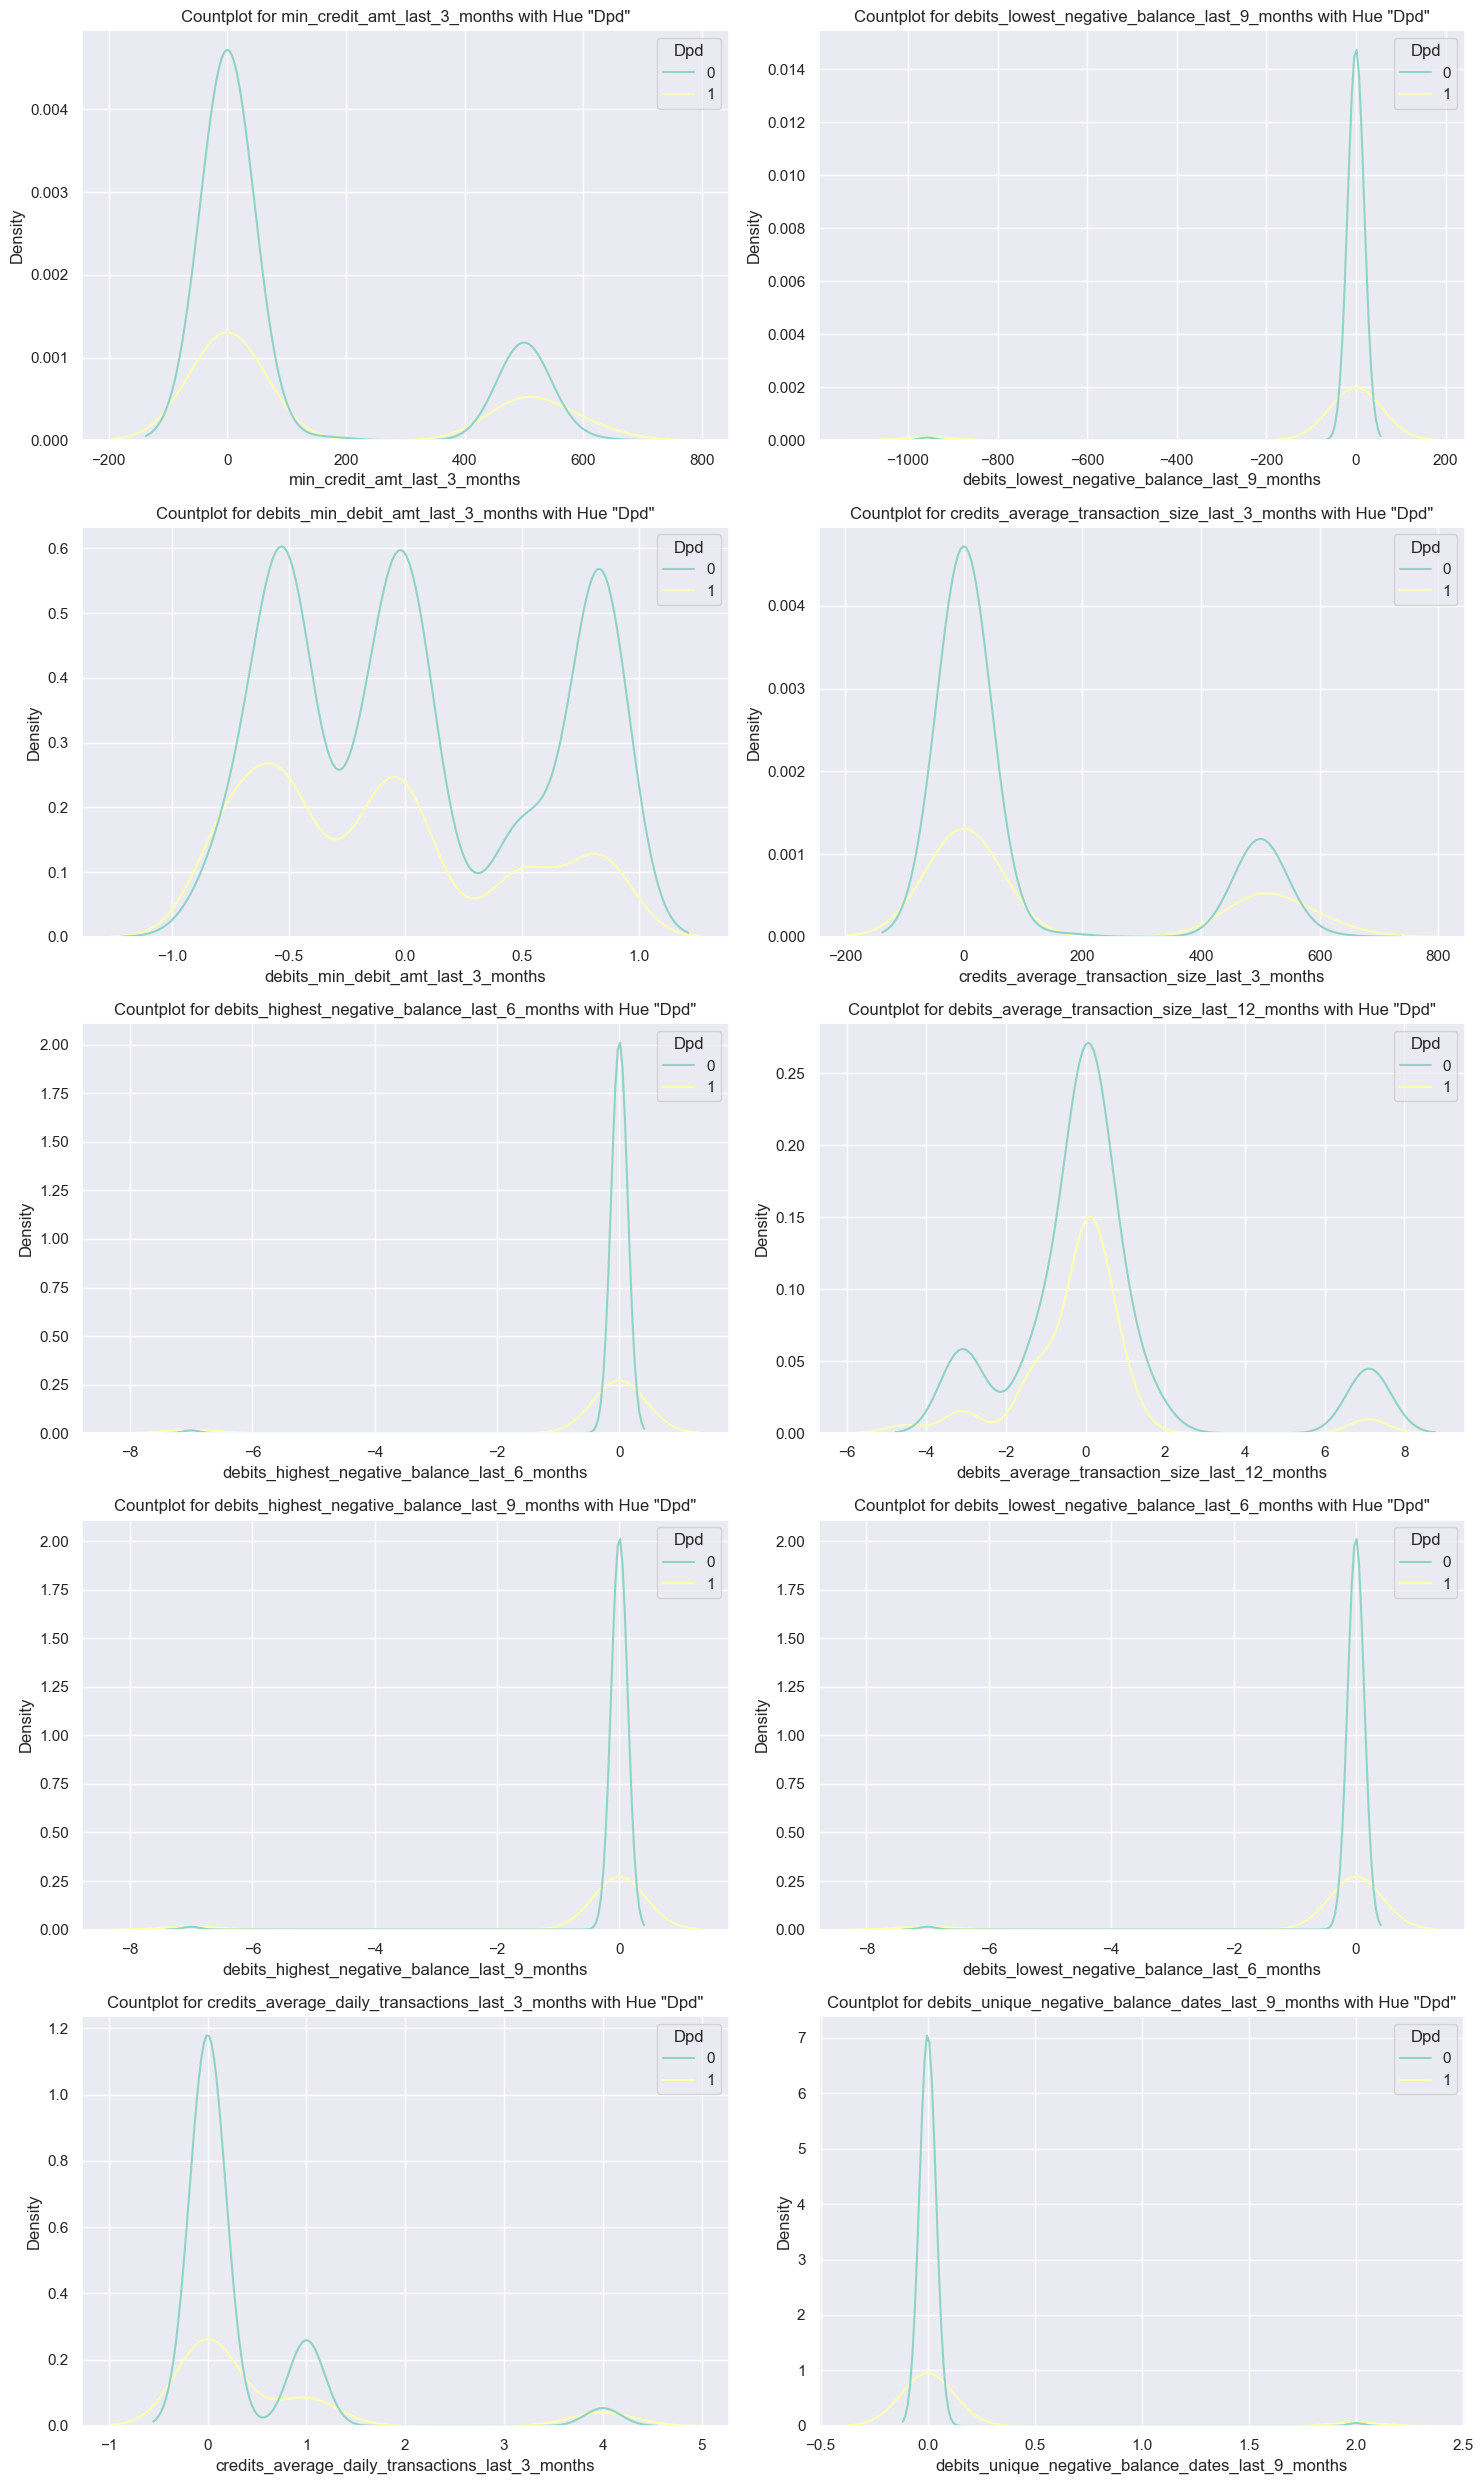

In [96]:
#Investigating feature relationships with Y

def X_y_relationship(data):
    data_cols = [col for col in data.columns if col != "Dpd"]
    
    data["Dpd"] = data["Dpd"].astype(str)
    num_cols = 2
    num_rows = (len(data_cols) + num_cols - 1) // num_cols  # Calculate the number of rows needed
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    
    axes = axes.flatten()
    
    for i, col in enumerate(data_cols):
        sns.kdeplot(x=col, data=data, palette="Set3", hue="Dpd", ax=axes[i])
        axes[i].set_title(f'Countplot for {col} with Hue "Dpd"')
        
    for i in range(len(data_cols), len(axes)):
        fig.delaxes(axes[i])
        
    plt.tight_layout()
    plt.show()
X_y_relationship=X_y_relationship(data)
X_y_relationship


In [109]:
#Label encode "DPd"
def Data_transformation(data):
 # Encoding
    encoder= LabelEncoder()
    data['Dpd'] = encoder.fit_transform(data[['Dpd']])
    # Scalling data
    cols_to_scale=['debits_min_debit_amt_last_3_months','debits_average_transaction_size_last_12_months']
    scaler = RobustScaler()
    data[cols_to_scale]=scaler.fit_transform(data[cols_to_scale])

    # Splitting ;Splitting Data- Hold-Out Validation
    X=data.drop('Dpd', axis=1).values
    y=data["Dpd"].values
    t_data=data
    print(f'X shape : {X.shape} \n y shape : {y.shape}')
    
    # train_test split
    X_train,X_test,y_train,y_test= train_test_split(X,y,train_size=0.9,test_size=0.1,random_state=0)
    print(f'X_train_shape :{X_train.shape}\n X_test-shape :{X_test.shape}\n y_train_shape: {y_train.shape}\ny_test_shape : {y_test.shape}')
    return X_train,X_test,y_train,y_test,t_data
    # X_train,X_test,y_train,y_test,t_data=Data_transformation(data)


 



In [110]:

# Confusion matrix
def plot_confusion_matrix(cm,classes=None,title='Confusion matrix'):
    if classes is not None:
        sns.heatmap(cm,cmap="YlGnBu",xticklabels=classes,yticklabels=classes,vmin=0,annot=True,annot_kws={'size':10})
    else:
        sns.heatmap(cm,vmin=0,vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Runing Decission Tree

In [127]:
def Decission_tree_model(data):
    
    '\n'

    
    
    dt=DecisionTreeClassifier(criterion='entropy',max_depth=2,random_state=1)
    dt.fit(X_train,y_train)
    predict_test=dt.predict(X_test)
    # Training accuracy
    print(f'Training Accuracy : {dt.score(X_train,y_train)}')
    #Test Accuracy
    print(f'Test Accuracy : {dt.score(X_test,y_test)}')

    # Feature importnace
    final_fi = pd.DataFrame()
    
    for i, column in enumerate(data.drop('Dpd', axis=1)):
        
        print(f'Importance Score {column}, {dt.feature_importances_[i]}')
    
        Fi = pd.DataFrame({'variable': [column], 'Feature Importance Score': [dt.feature_importances_[i]]})
    
        final_fi = pd.concat([final_fi, Fi], ignore_index=True)
    
    final_fi = final_fi.sort_values('Feature Importance Score', ascending=False).reset_index(drop=True)
    final_fi

    cm=confusion_matrix(y_test,predict_test)
    # normalize confussion atrix
    cm_norm=cm/cm.sum(axis=1)[:,np.newaxis]
    print(f'confussion Matrix :\n {cm}')
    plt.figure()
    plot_confusion_matrix(cm_norm,classes=dt.classes_,title='Training confusion')
    plt.show()
    return final_fi,dt,predict_test,cm


                           

In [122]:
# Getting False Positives(FP),False Negative(FN),True Positive(TP) and True Negtive(TN)
def model_evaluation(cm):
    # final_fi,rf,predict_test,cm=Random_forest_model(data=data_ingestion())
    # cm=
    FP=cm.sum(axis=0)-np.diag(cm)
    FN=cm.sum(axis=1)-np.diag(cm)
    TP=np.diag(cm)
    TN=cm.sum()-(FP+FN+TP)
    print(f'FP : {FP}\n FN : {FN} \n TP : {TP} \n TN : {TN}')
    
    #True Positive/Sensistiviy/Hit rate/Recall
    TPR=TP/(TP+FN)
    print(f'TPR: {TPR}')
    "\n"
    print(f'Average TPR : {TPR.sum()/2}')
    
    
    #Precisison/Positive Predictive Vallue
    PPV=TP/(TP+FP)
    "\n"
    print(f'PPV : {PPV}')
    print(f'Average PPV : {PPV.sum()/2}')
    
    #False Positive Rate/False alarm rate
    FPR= FP/(FP+TN)
    print(f'FPR : {FPR}')
    print(f'Average FPR : {FPR.sum()/2}')
    
    
    #False Negative Rate/Miss Rate
    FNR=FN/(FN+TP)
    print(f'FNR : {FNR}')
    print(f'Average FNR : {FNR.sum()/2}')
    
    
    #Classisfication Error
    CE=(FP+FN)/(TP+FP+FN+TN)
    
    #Overal Accuracy
    ACC=(TP+TN)/(TP+FP+FN+TN)
    print(f'Accuracy of each class is {ACC}')
    return TPR,PPV,FPR,FNR,CE,ACC
    # TPR,PPV,FPR,FNR,CE,ACC=mode_evaluation()
    # TPR
    
    
    #Total Average

In [45]:
# import graphviz
# dot_data=tree.export_graphviz(dt,out_file=None,feature_names=data.drop('Dpd',axis=1).columns,class_names=data['Dpd'].unique().astype(str),filled=True,rounded=True,special_characters=True)
# graph=graphviz.Source(dot_data)
# graph


### Model Tunning Tunning

In [137]:
 # GridSearchCV Tunning

def dt_tunning(X_train, y_train):
    # Define parameter grid
    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 2, 3, 4, 5],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    
    
    dt = DecisionTreeClassifier()
    
    #  cross-validation
    grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # best parameters
    best_params = grid_search.best_params_
    print("Best Parameters:", best_params)
    best_params_df = pd.DataFrame(grid_search.best_params_, index=[0])
    best_params_df 
    return best_params








### Final Random Forest_Model

In [138]:
def final_dt_model(best_params):
    # Train final model using best parameters
    final_model = DecisionTreeClassifier(**best_params)
    #Fitting the final model
    final_model.fit(X_train, y_train) 
    final_model_predict_test = final_model.predict(X=X_test)
    print(f'Classification Accuracy on test data with max_depth = {d} is {accuracy_score(y_test, predict_test)}')
    final_cm = confusion_matrix(y_test, predict_test)
    print(final_cm)
    cm_norm = final_cm / cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plot_confusion_matrix(cm_norm, classes=final_model.classes_,
                          title=f'Confusion matrix Accuracy on test set with max_depth={d} is {accuracy_score(y_test, predict_test)}')
    return final_model,final_cm


In [139]:
# Getting False Positives(FP),False Negative(FN),True Positive(TP) and True Negtive(TN)
def final_model_evaluation(final_cm):
    cm=final_cm
    FP=cm.sum(axis=0)-np.diag(cm)
    FN=cm.sum(axis=1)-np.diag(cm)
    TP=np.diag(cm)
    TN=cm.sum()-(FP+FN+TP)
    # print(f'FP : {FP}\n FN : {FN} \n TP : {TP} \n TN : {TN}')
    
    #True Positive/Sensistiviy/Hit rate/Recall
    final_TPR=TP/(TP+FN)
    print(f'final_TPR: {final_TPR}')
    "\n"
    print(f'Average final_TPR : {final_TPR.sum()/2}')
    
    
    #Precisison/Positive Predictive Vallue
    final_PPV=TP/(TP+FP)
    "\n"
    print(f'final_PPV : {final_PPV}')
    print(f'final_Average PPV : {final_PPV.sum()/2}')
    
    #False Positive Rate/False alarm rate
    final_FPR= FP/(FP+TN)
    print(f'final_FPR : {final_FPR}')
    print(f'final_Average FPR : {final_FPR.sum()/2}')
    
    
    #False Negative Rate/Miss Rate
    final_FNR=FN/(FN+TP)
    print(f'final_FNR : {final_FNR}')
    print(f'final_Average FNR : {final_FNR.sum()/2}')
    
    
    #Classisfication Error
    final_CE=(FP+FN)/(TP+FP+FN+TN)
    
    #Overal Accuracy
    final_ACC=(TP+TN)/(TP+FP+FN+TN)
    print(f'final_model Accuracy of each class is {final_ACC}')
    return final_TPR,final_PPV,final_FPR,final_FNR,final_CE


#Total Average

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2420 entries, 0 to 2419
Data columns (total 11 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   min_credit_amt_last_3_months                        2420 non-null   float64
 1   debits_lowest_negative_balance_last_9_months        2420 non-null   float64
 2   debits_min_debit_amt_last_3_months                  2420 non-null   float64
 3   credits_average_transaction_size_last_3_months      2420 non-null   float64
 4   debits_highest_negative_balance_last_6_months       2420 non-null   float64
 5   debits_average_transaction_size_last_12_months      2420 non-null   float64
 6   debits_highest_negative_balance_last_9_months       2420 non-null   float64
 7   debits_lowest_negative_balance_last_6_months        2420 non-null   float64
 8   credits_average_daily_transactions_last_3_months    2420 non-null   float64
 9

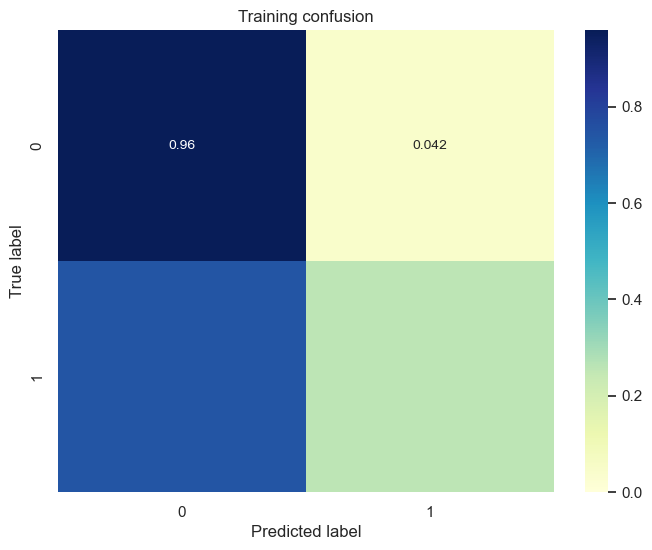

FP : [55  7]
 FN : [ 7 55] 
 TP : [161  19] 
 TN : [ 19 161]
TPR: [0.958333 0.256757]
Average TPR : 0.607545045045045
PPV : [0.745370 0.730769]
Average PPV : 0.7380698005698005
FPR : [0.743243 0.041667]
Average FPR : 0.3924549549549549
FNR : [0.041667 0.743243]
Average FNR : 0.3924549549549549
Accuracy of each class is [0.743802 0.743802]
Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Classification Accuracy on test data with max_depth = 5 is 0.743801652892562
[[161   7]
 [ 55  19]]
final_TPR: [0.958333 0.256757]
Average final_TPR : 0.607545045045045
final_PPV : [0.745370 0.730769]
final_Average PPV : 0.7380698005698005
final_FPR : [0.743243 0.041667]
final_Average FPR : 0.3924549549549549
final_FNR : [0.041667 0.743243]
final_Average FNR : 0.3924549549549549
final_model Accuracy of each class is [0.743802 0.743802]


(DecisionTreeClassifier(max_depth=3),
 array([0.958333, 0.256757]),
 array([0.745370, 0.730769]),
 array([0.743243, 0.041667]),
 array([0.041667, 0.743243]),
 array([0.256198, 0.256198]))

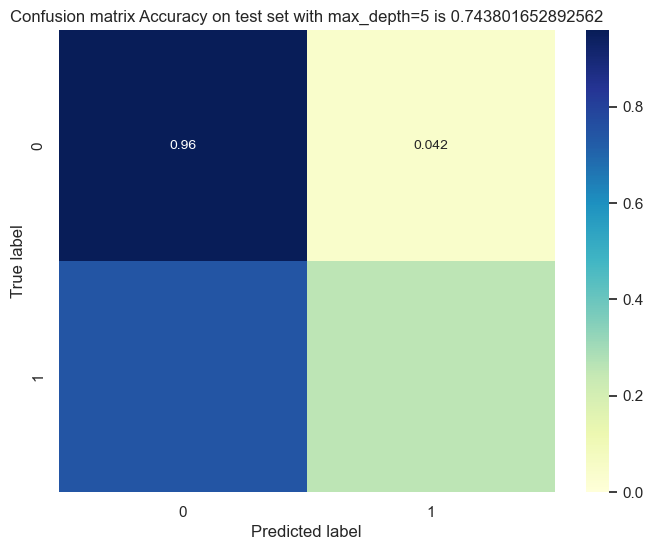

In [140]:
def call():
    data=data_ingestion()
    X_train,X_test,y_train,y_test,t_data=Data_transformation(data=data)
    final_fi,dt,predict_test,cm= Decission_tree_model(data=data) 
    PR,PPV,FPR,FNR,CE,ACC=model_evaluation(cm=cm)
    best_params=dt_tunning(X_train=X_train, y_train=y_train)
    final_model,final_cm=final_dt_model(best_params=best_params)
    final_TPR,final_PPV,final_FPR,final_FNR,final_CE=final_model_evaluation(final_cm=final_cm)

    return final_model,final_TPR,final_PPV,final_FPR,final_FNR,final_CE
tttt=call()
tttt